In [18]:
!pip install -qq tensorflow-datasets tensorflow matplotlib

In [19]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [20]:
# load the data from tfds
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

In [21]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/martin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

2023-11-20 12:47:43.496458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 12:47:43.496866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-11-20 12:47:43.547594: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

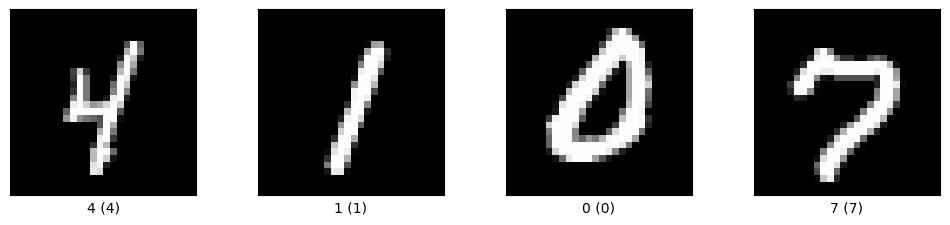

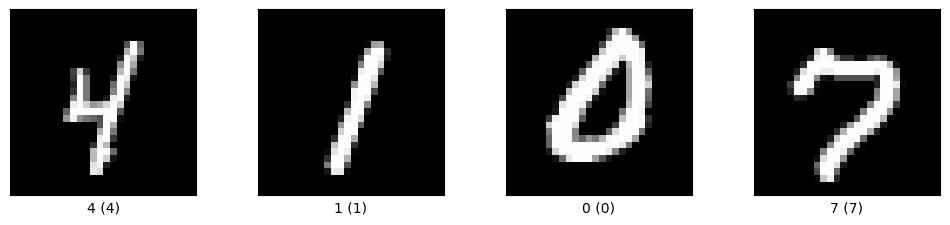

In [22]:
tfds.show_examples(train_ds, ds_info, rows=1, cols=4)

In [23]:
# data pipeline
def dataset(ds, mini_batch_size=512):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 128.0 - 1, y)) # normalize, 0~255 -> -1~1
    ds = ds.map(lambda x, y: (tf.reshape(x, (-1,)), y)) # flatten , 28x28 -> 784
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, 10))) # one-hot encoding
    ds = ds.shuffle(10000).batch(mini_batch_size) # shuffle and batch
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch with AUTOTUNE for performance

    return ds

In [24]:
# # sanity check
# ds = dataset(train_ds)
# for elem in ds.take(1):
#     print(elem)

In [25]:
# simple model of feed-forward Dense layers
class Model(tf.keras.Model):
    """
    Create a simple feed-forward model with Dense layers.
    """
    def __init__(self, dense_layers, output_shape, layers_activation, output_activation):
        """
        args:
            dense_layers: list of int, number of neurons in each dense layer
            output_shape: int, number of neurons in the output layer
            layers_activation: str/activation function, activation function of the dense layers
            output_activation: str/activation function, activation function of the output layer
        """
        super(Model, self).__init__()
        self.__layers = []
        for layer in dense_layers:
            self.__layers.append(tf.keras.layers.Dense(layer, activation=layers_activation))
        self.__layers.append(tf.keras.layers.Dense(output_shape, activation=output_activation))

    def call(self, inputs):
        x = inputs
        for layer in self.__layers:
            x = layer(x)
        return x

In [26]:
from tqdm import tqdm

def training_loop(model, train, test, loss, opt, epochs=100):
    """
    Train the model with the given training and test datasets.
    args:
        model: tf.keras.Model, the model to train
        train: tf.data.Dataset, the training dataset
        test: tf.data.Dataset, the test dataset
        loss: tf.keras.losses, the loss function
        opt: tf.keras.optimizers, the optimizer
        epochs: int, number of epochs to train
    return:
        metrics: dict, training and test metrics
    """
    train_loss = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_loss = tf.keras.metrics.Mean()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    for epoch in tqdm(range(epochs), desc='Epochs'):
        for x, y in train:
            with tf.GradientTape() as tape:
                y_pred = model(x)
                loss_value = loss(y, y_pred)
            grads = tape.gradient(loss_value, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss(loss_value)
            train_accuracy(y, y_pred)
        
        for x, y in test:
            y_pred = model(x)
            loss_value = loss(y, y_pred)
            
            test_loss(loss_value)
            test_accuracy(y, y_pred)

        metrics['train_loss'].append(train_loss.result().numpy())
        metrics['train_accuracy'].append(train_accuracy.result().numpy())
        metrics['test_loss'].append(test_loss.result().numpy())
        metrics['test_accuracy'].append(test_accuracy.result().numpy())

        print(f'Train Loss: {metrics["train_loss"][-1]:.4f}, Train Accuracy: {metrics["train_accuracy"][-1]:.4f}')
        print(f'Test Loss: {metrics["test_loss"][-1]:.4f}, Test Accuracy: {metrics["test_accuracy"][-1]:.4f}')
        print()

    return metrics


In [27]:
# plotting, saving and loading metrics
import matplotlib.pyplot as plt
import json
import numpy as np

def save_model_info(file_name, model_info):
    """
    Save the model info to a json file.
    args:
        file_name: str, name of the json file
        model_info: dict, model info
    """
    with open(file_name, 'w') as f:
        json.dump(model_info, f)

def save_metrics(model, metrics, hyper_parameter, model_type,file_name='metrics.json', model_description=""):
    """
    Save the metrics of the model to a json file.
    args:
        model: tf.keras.Model, the model to train
        metrics: dict, training and test metrics
        hyper_parameter: dict, hyper parameter of the model
        type: str, type of the model
        file_name: str, name of the json file
    """
    # round the measurmenrs to 4 decimal places
    for key, value in metrics.items():
        metrics[key] = [np.around(float(x), 4) for x in value]
    
    # add the number of parameters to the metrics
    params = model.count_params()

    # initialize the model info dict
    model_info = {
                "description": model_description ,
                "type": model_type,
                "parameter_count": params,
                "hyper_parameter": hyper_parameter,
                "metrics": metrics,
                "accuracy_test": metrics['test_accuracy'][-1],
                "accuracy_train": metrics['train_accuracy'][-1],
                "loss_test": metrics['test_loss'][-1],
                "loss_train": metrics['train_loss'][-1],
                }
    
    # save the model info to a json file
    save_model_info(file_name, model_info)

def load_metrics(file_name='metrics.json'):
    """
    Load the metrics of the model from a json file.
    """
    with open(file_name, 'r') as f:
        model_info = json.load(f)
    return model_info
    

def visualize(metrics, fig_title = "",max_steps = 20):

    # set the x-axis ticks
    epoch_idx = range(1,len(metrics['test_loss']) + 1)
    x_ticks = list(epoch_idx)
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]

    # Create a figure with two subplots (axes)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(fig_title)

    # Plot test loss and accuracy
    line3, = ax1.plot(epoch_idx, metrics['test_loss'], 'r-')
    line4, = ax1.plot(epoch_idx, metrics['train_loss'], 'b-')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend([line3, line4], ['Test Loss', 'Train Loss'])
    ax1.set_title('Loss, Train - Test')
    ax1.set_xticks(x_ticks)
    ax1.grid(True)

    # Plot training loss and accuracy
    line1, = ax2.plot(epoch_idx, metrics['test_accuracy'], 'r--')
    line2, = ax2.plot(epoch_idx, metrics['train_accuracy'], 'b--')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend([line1, line2], ['Test Accuracy', 'Train Accuracy'])
    ax2.set_title('Accuracy, Train - Test')
    ax2.set_xticks(x_ticks)
    ax2.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


def plot_model_comparision(models:list, max_steps = 20):
    """
    Plot the test accuracy of the given models.
    """
    fig , ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.suptitle("Model Comparision")

    # set the x-axis ticks
    
    metrics_lenght = len(load_metrics(models[0])['metrics']['test_loss'])
    epoch_idx = range(1,metrics_lenght + 1)
    x_ticks = list(epoch_idx)
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]

    for model in models:
        model_info = load_metrics(model)
        model_metrics = model_info['metrics']
        model_hyper_parameter = model_info['hyper_parameter']
        label = f"{model_info['type']}_{len(model_hyper_parameter['DENSE_LAYERS'])}: {model_info['parameter_count']:,}"
        ax.plot(epoch_idx, model_metrics['test_accuracy'], label=label)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Test Accuracy')
    ax.set_xticks(x_ticks)
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

### Hyperparameters

In [28]:
class Model_Convolve(tf.keras.Model):
    """
    a simple CNN model with 2 Conv2D layers and 2 MaxPooling2D layers
    """
    def __init__(self):
        super(Model_Convolve, self).__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 28, 28, 1])
        return self.seq(x)

In [29]:
# configuration of the hyper parameters
DENSE_LAYERS = [16,16]
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_SCHEDULER = True
OPTIMIZER = "SGD"

TYPE = 'dense' # dense or conv

train_data = dataset(train_ds, BATCH_SIZE)
test_data = dataset(test_ds, BATCH_SIZE)

In [30]:
# initialize the model
if TYPE == 'dense':
    model = Model(DENSE_LAYERS, 10, 'relu', 'softmax')
elif TYPE == 'conv':
    model = Model_Convolve()

loss = tf.keras.losses.CategoricalCrossentropy()
if USE_SCHEDULER:
    lr_fn = tf.optimizers.schedules.PolynomialDecay(LEARNING_RATE*0.1, EPOCHS, LEARNING_RATE*10, 2) # use a scheduler to decay the learning rate over time
    if OPTIMIZER == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=lr_fn, momentum=MOMENTUM)
    elif OPTIMIZER == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr_fn)
else:
    if OPTIMIZER == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)
    elif OPTIMIZER == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [31]:
# train the modle and get the metrics of the training
metrics = training_loop(model, train_data, test_data, loss, opt, EPOCHS)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-20 12:47:43.970954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 12:47:43.971616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 12:47:51.206313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{nod

Train Loss: 0.5742, Train Accuracy: 0.8163
Test Loss: 0.3215, Test Accuracy: 0.9047



Epochs:  20%|██        | 2/10 [00:15<01:01,  7.71s/it]

Train Loss: 0.4406, Train Accuracy: 0.8625
Test Loss: 0.2890, Test Accuracy: 0.9157



Epochs:  30%|███       | 3/10 [00:22<00:52,  7.48s/it]

Train Loss: 0.3824, Train Accuracy: 0.8818
Test Loss: 0.2846, Test Accuracy: 0.9148



Epochs:  40%|████      | 4/10 [00:29<00:43,  7.25s/it]

Train Loss: 0.3479, Train Accuracy: 0.8931
Test Loss: 0.2741, Test Accuracy: 0.9170



Epochs:  50%|█████     | 5/10 [00:36<00:36,  7.20s/it]

Train Loss: 0.3230, Train Accuracy: 0.9012
Test Loss: 0.2609, Test Accuracy: 0.9210



Epochs:  60%|██████    | 6/10 [00:43<00:28,  7.12s/it]

Train Loss: 0.3036, Train Accuracy: 0.9072
Test Loss: 0.2528, Test Accuracy: 0.9235



Epochs:  70%|███████   | 7/10 [00:51<00:21,  7.21s/it]

Train Loss: 0.2881, Train Accuracy: 0.9121
Test Loss: 0.2457, Test Accuracy: 0.9259



Epochs:  80%|████████  | 8/10 [00:58<00:14,  7.21s/it]

Train Loss: 0.2757, Train Accuracy: 0.9160
Test Loss: 0.2399, Test Accuracy: 0.9275



Epochs:  90%|█████████ | 9/10 [01:05<00:07,  7.18s/it]

Train Loss: 0.2652, Train Accuracy: 0.9194
Test Loss: 0.2338, Test Accuracy: 0.9296



Epochs: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]

Train Loss: 0.2562, Train Accuracy: 0.9223
Test Loss: 0.2303, Test Accuracy: 0.9306



In [32]:
# save the metrics and model meta data to a json file
hyper_parameter = {
    'DENSE_LAYERS': DENSE_LAYERS,
    'EPOCHS': EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'LEARNING_RATE': LEARNING_RATE,
    'MOMENTUM': MOMENTUM,
    'USE_SCHEDULER': USE_SCHEDULER,
    'OPTIMIZER': OPTIMIZER
}

file_name = f'./epochs_{EPOCHS}/' + 'metrics_12.json'
save_metrics(model, metrics, hyper_parameter, TYPE, file_name)

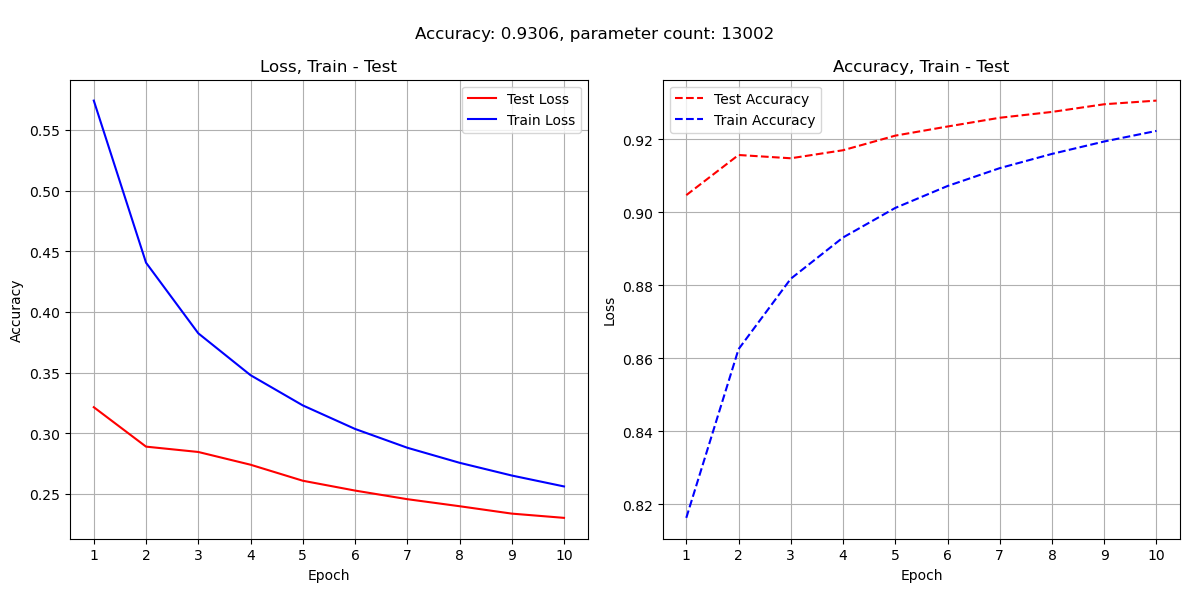

In [33]:
# visualize the metrics

# file_name = "./epochs_10/metrics_12.json"
with open(file_name, 'r') as f:
    model_info = json.load(f)

visualize(model_info['metrics'],
 f"{model_info['description']}\nAccuracy: {model_info['accuracy_test']:.4f}, parameter count: {model_info['parameter_count']}") # visualize the metrics with title from a json file

# visualize(metrics) # direct visualization from the metrics dict


In [34]:
# compare multiple models from json files both tabularly and graphically
import pandas as pd

def compare_models(models_to_compare, plot=True):


    # Define columns for the DataFrame
    columns = ['model', 'layers', '#params', 'lr', 'momentum', 'mini_batch', 'epochs', 'optimizer', 'accuracy_test', 'accuracy_train']
    df = pd.DataFrame(columns=columns)

    for model in models_to_compare:
        model_info = load_metrics(model)
        model_hyper_parameter = model_info['hyper_parameter']

        # Create a new entry as a dictionary ensuring all columns are covered
        new_entry = {
            'model': model_info['description'],
            'layers': model_hyper_parameter.get('DENSE_LAYERS', pd.NA),  # Using pd.NA for missing values
            '#params': model_info['parameter_count'],
            'lr': model_hyper_parameter.get('LEARNING_RATE', pd.NA),
            'momentum': model_hyper_parameter.get('MOMENTUM', pd.NA),
            'mini_batch': model_hyper_parameter.get('BATCH_SIZE', pd.NA),
            'epochs': model_hyper_parameter.get('EPOCHS', pd.NA),
            'optimizer': model_hyper_parameter.get('OPTIMIZER', pd.NA),
            'accuracy_test': model_info.get('accuracy_test', pd.NA),
            'accuracy_train': model_info.get('accuracy_train', pd.NA)
        }

        # Convert the dictionary to a DataFrame and concatenate
        new_entry_df = pd.DataFrame([new_entry], columns=columns)
        df = pd.concat([df, new_entry_df], ignore_index=True)

    df = df.sort_values(by=['accuracy_test'], ascending=False)
    # print(df.to_string())

    if plot:
        plot_model_comparision(models_to_compare)

    return df

/tmp/ipykernel_7906/1170558275.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_entry_df], ignore_index=True)


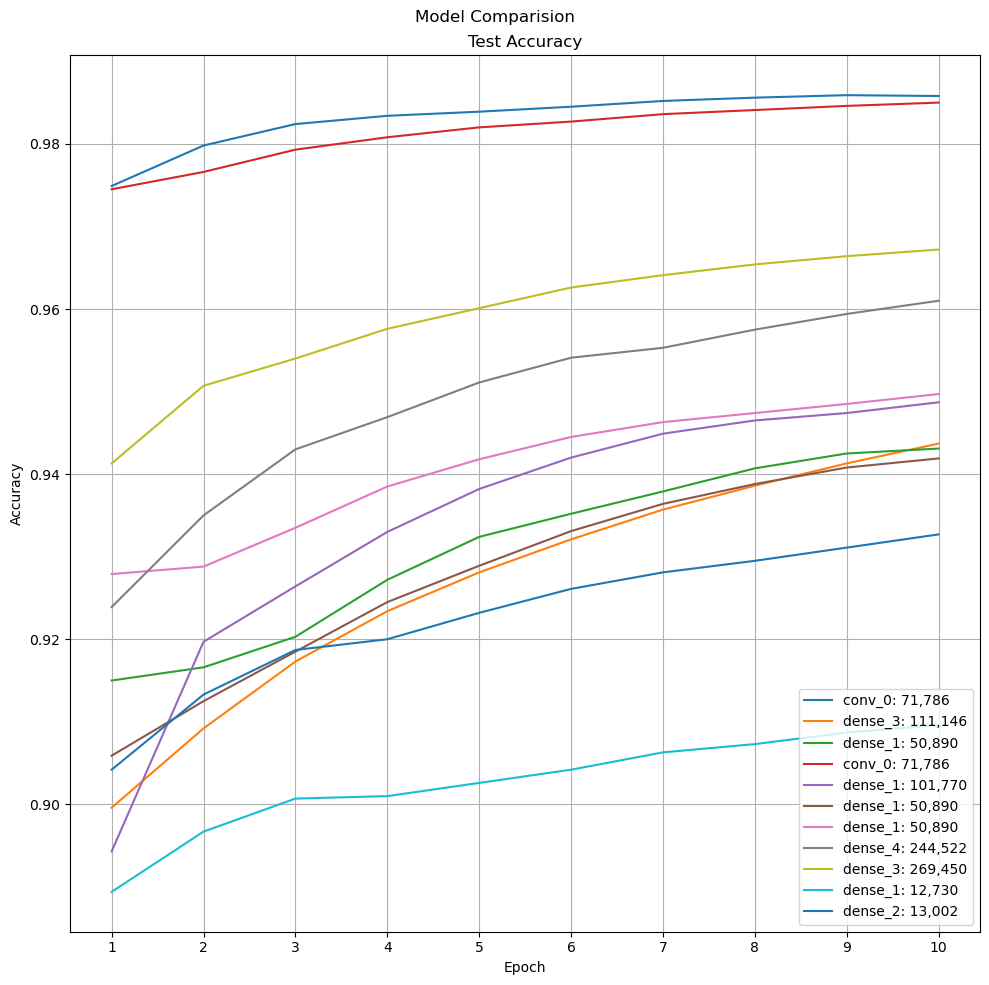

,model,layers,#params,lr,momentum,mini_batch,epochs,optimizer,accuracy_test,accuracy_train
0,CNN_2Conv_2MaxPool_1Dense,[],71786,0.010,0.9,512,10,Adam,0.9858,0.9825
3,CNN_2Conv_2MaxPool_1Dense,[],71786,0.010,0.9,512,10,SGD,0.9850,0.9735
8,Dense_3,"[256, 128, 256]",269450,0.002,0.9,256,10,Adam,0.9672,0.9657
7,Dense_4,"[256, 128, 64, 32]",244522,0.001,0.9,512,10,Adam,0.9610,0.9553
6,Dense_1,[64],50890,0.010,0.5,128,10,SGD,0.9497,0.9434
4,Dense_1,[128],101770,0.010,0.9,512,10,SGD,0.9487,0.9459
1,Dense_3,"[128, 64, 32]",111146,0.001,0.9,512,10,SGD,0.9437,0.9238
2,Dense_1,[64],50890,0.010,0.9,256,10,SGD,0.9431,0.9389
5,Dense_1,[64],50890,0.010,0.5,256,10,SGD,0.9419,0.9379
10,Dense_2,"[16, 16]",13002,0.001,0.9,128,10,Adam,0.9327,0.9219


In [35]:
models_path = "./epochs_10/"
models_files = ["metrics_00.json","metrics_01.json",
                    "metrics_02.json", "metrics_03.json",
                    "metrics_04.json", "metrics_05.json",
                    "metrics_06.json", "metrics_07.json",
                    "metrics_08.json", "metrics_09.json",
                    "metrics_10.json", "metrics_11.json"]
models_to_compare = [models_path + model for model in models_files] # add the path to the models
df = compare_models([models_to_compare[0]] + models_to_compare[2:], plot=True)
df

### analysis of the results
for the analysis we will briefly discuss the results of the following 4 DenseNet models and the best performing model (CNN):
-All models were trained for 10 epochs

A - Denes - [64] neurons - LR: 0.01 - momentum: 0.5 - batch size: 128 - opt: SGD - params: 50890 
B - Dense - [64] neurons - LR: 0.01 - momentum: 0.5 - batch size: 256 - opt: SGD - params: 50890 
C - Dense - [16] neurons - LR: 0.001 - momentum: 0.9 - batch size: 64 - opt: Adam - params: 12730 
D - Dense - [128, 64, 32] neurons - LR: 0.01 - momentum: 0.9 - batch size: 256 - opt: SGD - params: 111146

- model A has performed better than larger models and same models with varient RL and momentum ( B and D and other similar ones) what sat it apart was the smaller batch size, which allowed for more frequent updates to the weights, where as model D proved to be too large for the learning rate of 0.01 on the given task, and could not converge at all, model C of only one hidden layer of 16 neurons proved to perform comparaply well with over 90% accuracy, and smaller batches proved better than larger ones, as well as smaller LR and higher momentum.

the closest we got to a CNN performance (98.5%) was with model A (95%), and next with condedirably larger moodels not included in the anaylsis above, [256, 128, 256] with (96.7%) ...

## --- IGNORE BELOW ---- 


adjust hyper parameter across moduls:

In [15]:
def train_from_json(file_name, **override_hyper_parameter):
    """
    Load the model from a json file and optionally override the hyper parameters
    args:
        file_name: str, name of the json file
        override_hyper_parameter: dict, hyper parameters to override
    return:
        model: tf.keras.Model, the model to train
        train_data: tf.data.Dataset, the training dataset
        test_data: tf.data.Dataset, the test dataset
        hyper_parameter: dict, hyper parameter of the model
    """
    with open(file_name, 'r') as f:
        model_info = json.load(f)
    
    hyper_parameter = model_info['hyper_parameter']
    hyper_parameter.update(override_hyper_parameter)

    if model_info['description'].startswith('Dense'):
        model = Model(hyper_parameter['DENSE_LAYERS'], 10, 'relu', 'softmax')
    elif model_info['description'].startswith('CNN'):
        model = Model_Convolve()
 
    loss = tf.keras.losses.CategoricalCrossentropy()
    if hyper_parameter['USE_SCHEDULER']:
        lr_fn = tf.optimizers.schedules.PolynomialDecay(hyper_parameter['LEARNING_RATE']*0.1, hyper_parameter['EPOCHS'], hyper_parameter['LEARNING_RATE']*10, 2) # use a scheduler to decay the learning rate over time
        if hyper_parameter['OPTIMIZER'] == 'Adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr_fn)
        else:
            opt = tf.keras.optimizers.SGD(learning_rate=lr_fn, momentum=hyper_parameter['MOMENTUM'])
    else:
        if hyper_parameter['OPTIMIZER'] == 'Adam':
            opt = tf.keras.optimizers.Adam(learning_rate=hyper_parameter['LEARNING_RATE'])
        else:
            opt = tf.keras.optimizers.SGD(learning_rate=hyper_parameter['LEARNING_RATE'], momentum=hyper_parameter['MOMENTUM'])
    
    train_data = dataset(train_ds, hyper_parameter['BATCH_SIZE'])
    test_data = dataset(test_ds, hyper_parameter['BATCH_SIZE'])

    # build the model

    metrics = training_loop(model, train_data, test_data, loss, opt, hyper_parameter['EPOCHS'])
    
    for key, value in metrics.items():
        metrics[key] = [np.around(float(x), 4) for x in value]

    model_info['metrics'] = metrics
    model_info['hyper_parameter'] = hyper_parameter

    model_info['accuracy_test'] = metrics['test_accuracy'][-1]
    model_info['accuracy_train'] = metrics['train_accuracy'][-1]
    model_info['loss_test'] = metrics['test_loss'][-1]
    model_info['loss_train'] = metrics['train_loss'][-1]

    model_info['parameter_count'] = model.count_params()

    return model_info


set some hypermeter you want to change/unify across moduls

In [ ]:

# run already saved models for x epochs
NEW_EPOCHS = 10
new_USE_SCHEDULER = False

models_path = "./epochs_10/"
models_files = ["metrics_00.json","metrics_01.json",
                    "metrics_02.json", "metrics_03.json",
                    "metrics_04.json", "metrics_05.json",
                    "metrics_06.json", "metrics_07.json",
                    "metrics_08.json", "metrics_09.json",
                    "metrics_10.json", "metrics_11.json"]

models_files = models_files
models_to_compare = [models_path + model for model in models_files] # add the path to the models

new_models_path = f"./epochs_{NEW_EPOCHS}/" if new_USE_SCHEDULER else f"./epochs_{NEW_EPOCHS}_no_scheduler/"
                 
for idx, model_file in enumerate(models_to_compare):

    new_model_info = train_from_json(model_file, EPOCHS=NEW_EPOCHS, USE_SCHEDULER=new_USE_SCHEDULER)
     
    new_model_file = new_models_path + models_files[idx]
    save_model_info(new_model_file, new_model_info)


/tmp/ipykernel_7906/1170558275.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_entry_df], ignore_index=True)


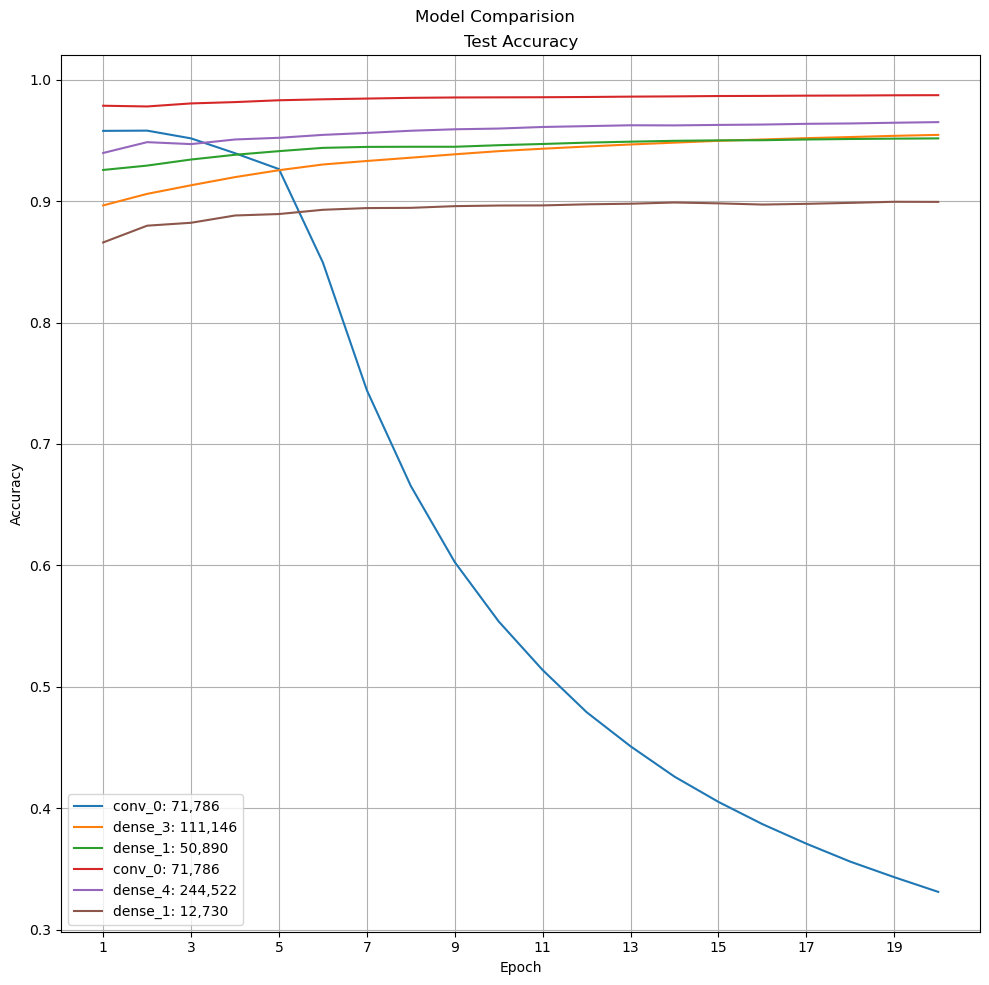

,model,layers,#params,lr,momentum,mini_batch,epochs,optimizer,accuracy_test,accuracy_train
3,CNN_2Conv_2MaxPool_1Dense,[],71786,0.010,0.9,512,20,SGD,0.9873,0.9867
4,Dense_4,"[256, 128, 64, 32]",244522,0.001,0.9,512,20,Adam,0.9651,0.9676
1,Dense_3,"[128, 64, 32]",111146,0.001,0.9,512,20,SGD,0.9546,0.9479
2,Dense_1,[64],50890,0.010,0.9,256,20,SGD,0.9517,0.9545
5,Dense_1,[16],12730,0.001,0.9,64,20,Adam,0.8994,0.8990
0,CNN_2Conv_2MaxPool_1Dense,[],71786,0.010,0.9,512,20,Adam,0.3311,0.3568


In [43]:
models_path = "./epochs_20/"
models_files = ["metrics_00.json","metrics_01.json",
                    "metrics_02.json", "metrics_03.json",
                    "metrics_04.json", "metrics_05.json",
                    "metrics_06.json", "metrics_07.json",
                    "metrics_08.json", "metrics_09.json",
                    "metrics_10.json", "metrics_11.json"]
models = [0,2,3,4,8,10]
models_files = [models_files[i] for i in models]
models_to_compare = [models_path + model for model in models_files] # add the path to the models
df = compare_models(models_to_compare, plot=True)
df